## Design Decisions
### Design Decision 1: **Sentence Chunking (`sentences_per_chunk`)**
**Service Area**: Extraction Service

**Significance**:
The `sentences_per_chunk` parameter determines how the documents in the corpus are divided into chunks of sentences. This design decision is crucial because it directly impacts the granularity of the text that is encoded into embeddings. Smaller chunks can provide more fine-grained context retrieval but may lose broader contextual information. Larger chunks may capture more context but could dilute the relevance of specific information.

**Analysis Plan**:
To analyze the impact of different chunk sizes, I would:
1. Experiment with varying values of `sentences_per_chunk` (e.g., 1, 3, 5, 10).
2. Measure retrieval performance using metrics like precision, recall, and F1-score on a validation set.
3. Evaluate the trade-offs between the granularity of the retrieved information and the overall retrieval relevance.
4. Conduct user testing to determine which chunk size provides the most useful responses in real-world scenarios.

**Expected Outcome**:
I expect that there will be an optimal chunk size that balances the need for detailed information with the need to maintain meaningful context. The analysis will guide the selection of this optimal value.

---

### Design Decision 2: **Top-k Retrieval (`top_k`)**
**Service Area**: Retrieval Service

**Significance**:
The `top_k` parameter defines how many of the most relevant context chunks are retrieved for a given question. This is a critical design decision because retrieving too few chunks might miss important context, while retrieving too many might include irrelevant information, increasing computational overhead and potentially confusing the generator model.

**Analysis Plan**:
To analyze the impact of different values for `top_k`, I would:
1. Experiment with various values of `top_k` (e.g., 3, 5, 10, 20).
2. Measure the performance of the generated answers using evaluation metrics like accuracy and relevance scores.
3. Assess the balance between retrieval precision and the richness of context provided.
4. Analyze the computational cost associated with different values of `top_k`.

**Expected Outcome**:
I expect to find an optimal range for `top_k` that maximizes the accuracy and relevance of the generated answers while minimizing unnecessary computational effort.

---

### Design Decision 3: **Embedding Model Choice**
**Service Area**: Extraction Service

**Significance**:
The choice of the embedding model (e.g., `all-MiniLM-L6-v2`) is foundational to the entire pipeline, as it determines how text is represented in the embedding space. Different models may capture different nuances of the language, affecting the accuracy of retrieval and the quality of generated answers.

**Analysis Plan**:
To analyze the impact of different embedding models, I would:
1. Compare multiple pre-trained models (e.g., BERT variants, Sentence Transformers).
2. Evaluate their performance on encoding the corpus by measuring retrieval effectiveness (using MRR, precision, recall) and answer quality.
3. Conduct ablation studies to determine how each model affects the downstream tasks in the pipeline.
4. Consider computational efficiency, as some models may require more resources.

**Expected Outcome**:
I anticipate that a model with a good balance between contextual understanding and computational efficiency will be identified, leading to better overall performance in retrieval and generation tasks.

---

### Design Decision 4: **KDTree for Efficient Retrieval**
**Service Area**: Retrieval Service

**Significance**:
The use of a KDTree for efficient nearest neighbor search is a key design choice that affects the system's scalability and speed. As the number of documents grows, the retrieval process needs to remain efficient. The KDTree structure helps in quickly locating the most relevant chunks, but its effectiveness depends on the embedding dimensionality and the number of stored embeddings.

**Analysis Plan**:
To analyze the effectiveness of using a KDTree, I would:
1. Measure the retrieval speed and accuracy as the size of the corpus increases.
2. Compare the performance of KDTree against other retrieval structures (e.g., brute-force search, approximate nearest neighbor methods).
3. Evaluate how the dimensionality (`k`) of the embeddings affects KDTree's performance in terms of speed and retrieval accuracy.

**Expected Outcome**:
I expect that the KDTree will provide efficient retrieval with acceptable accuracy for moderate-sized datasets. However, if the corpus grows significantly, alternative retrieval strategies may be necessary to maintain performance.

---

### Design Decision 5: **Context and Answer Generation Quality**
**Service Area**: Generator Service

**Significance**:
The quality of the generated answers is paramount for the system's success. This depends on how well the context retrieved by the KDTree is used by the BERT model to generate relevant and accurate answers. The BERT model must effectively utilize the provided context to deliver answers that are not only accurate but also contextually rich.

**Analysis Plan**:
To analyze the generation quality, I would:
1. Measure the relevance and correctness of generated answers using metrics like BLEU, ROUGE, and human evaluations.
2. Experiment with different strategies for combining and formatting the retrieved context before feeding it to the BERT model.
3. Analyze how different values of `top_k` and `sentences_per_chunk` impact the quality of the generated answers.
4. Conduct user satisfaction surveys to gather qualitative feedback on the system's output.

**Expected Outcome**:
I anticipate that optimizing the combination of retrieved contexts will lead to significant improvements in the quality of generated answers. This will likely involve fine-tuning the BERT model and adjusting how context is provided to the model.

## In Depth Analysis of Two Design Decisions

In [1]:
import sys
sys.path.append('../')
import os
import shutil
import csv
import pandas as pd
from tqdm import tqdm
from pipeline import Pipeline
import matplotlib.pyplot as plt

os.chdir('../')
print(os.getcwd())

import warnings 
warnings.filterwarnings('ignore') 

# Path to the CSV file
csv_file_path = "qa_resources/questions.csv"

# Read the CSV file and prepare the data for the /evaluate endpoint
questions_data = []
with open(csv_file_path, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t')
    for row in reader:
        question = row['Question']
        answer = row['Answer']
        if question and answer:
            questions_data.append({
                "question": question,
                "ground_truth": answer
            })

c:\Users\josem\Desktop\JHU\705.603 - Creating AI Enabled-Systems\Assignments\marquezjaramillo-jose\visual_search_system\vs_venv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


c:\Users\josem\Desktop\JHU\705.603 - Creating AI Enabled-Systems\Assignments\marquezjaramillo-jose\retrieval_augmented_generation


In [2]:
# Step 1: Empty the `storage/embeddings` directory
def clear_embeddings_directory(embeddings_dir='storage/embeddings'):
    print('Clearing embeddings')
    if os.path.exists(embeddings_dir):
        shutil.rmtree(embeddings_dir)  # Remove the directory and all its contents
        os.makedirs(embeddings_dir)  # Recreate the directory
    else:
        os.makedirs(embeddings_dir)  # Create the directory if it doesn't exist
    print('Embeddings cleared')

# Step 2: Initialize a new Pipeline
def initialize_pipeline(**kwargs):
    pipeline = Pipeline(**kwargs)
    print(f'Pipeline initiated with {kwargs}')
    return pipeline

# Step 3: Evaluate a series of questions
def evaluate_questions(pipeline, questions):
    results = []

    for q in tqdm(questions, desc='Questions'):
        question = q['question']
        ground_truth = q['ground_truth']
        ground_truth, model_answer, score, match_result = pipeline.evaluate_question(question, ground_truth)
        results.append({
            'Question': question,
            'Ground Truth': ground_truth,
            'Model Answer': model_answer,
            'Score': score,
            'Match Result': match_result
        })

    return results

# Step 4: Iterate over different parameters
def iterate_over_parameters(params: dict[list]):
    results = None
    param = list(params.keys())[0]
    param_values = params[param]
    for k in param_values:
        print(f"\n\n Evaluating for {param}={k}")
        clear_embeddings_directory()
        pipeline = initialize_pipeline(**{param:k})
        result = pd.DataFrame(evaluate_questions(pipeline, questions_data))  
        result[param]=k
        if results is None:
            results = result
        else:
            results = pd.concat([results, result])
    return results

In [3]:
def plot_results(results, params):
    df = results.copy()
    param = list(params.keys())[0]
    match_result_percentage = df.groupby(param)['Match Result'].sum() 

    # Group by 'top_k' and calculate the average 'Score'
    average_score = df.groupby(param)['Score'].mean()

    # Create the plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    # Plot the Match Result percentages
    match_result_percentage.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
    axes[0].set_title(f'True Match Results by {param}')
    axes[0].set_xlabel(param)
    axes[0].set_ylabel('Number of True')
    axes[0].set_ylim(0, len(questions_data))

    # Plot the Average Score
    average_score.plot(kind='bar', ax=axes[1], color='salmon', edgecolor='black')
    axes[1].set_title(f'Average Score by {param}')
    axes[1].set_xlabel(param)
    axes[1].set_ylabel('Average Score')
    axes[1].set_ylim(0, 1)

    # Adjust layout
    plt.tight_layout()

    plt.show()

### Detailed Analysis of Sentence Chunking Results

In [4]:
params = {'sentences_per_chunk':[1, 2, 3, 5]}
sentences_per_chunk_results = iterate_over_parameters(params)



 Evaluating for sentences_per_chunk=1
Clearing embeddings
Embeddings cleared


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using device: cuda
Pipeline initiated with {'sentences_per_chunk': 1}


Questions: 100%|██████████| 109/109 [00:56<00:00,  1.93it/s]




 Evaluating for sentences_per_chunk=2
Clearing embeddings
Embeddings cleared


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using device: cuda
Pipeline initiated with {'sentences_per_chunk': 2}


Questions: 100%|██████████| 109/109 [01:19<00:00,  1.37it/s]




 Evaluating for sentences_per_chunk=3
Clearing embeddings
Embeddings cleared


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using device: cuda
Pipeline initiated with {'sentences_per_chunk': 3}


Questions: 100%|██████████| 109/109 [01:38<00:00,  1.11it/s]




 Evaluating for sentences_per_chunk=5
Clearing embeddings
Embeddings cleared


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using device: cuda
Pipeline initiated with {'sentences_per_chunk': 5}


Questions: 100%|██████████| 109/109 [02:30<00:00,  1.38s/it]


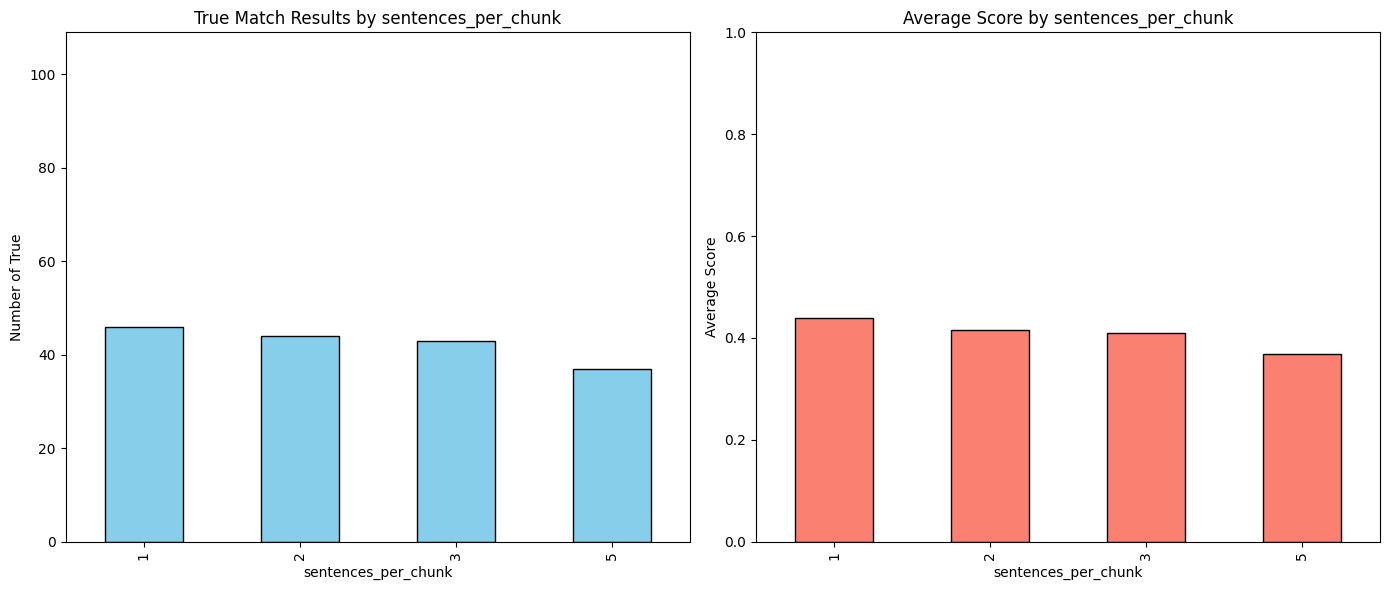

In [5]:
plot_results(sentences_per_chunk_results, params)

In [9]:
sentences_per_chunk_results.groupby('sentences_per_chunk')[['Match Result','Score']].agg(['sum','mean']).reset_index()

sentences_per_chunk Match Result                Score          
                               sum      mean        sum      mean
0                   1           46  0.422018  47.891265  0.439369
1                   2           44  0.403670  45.343510  0.415996
2                   3           43  0.394495  44.618983  0.409348
3                   5           37  0.339450  40.195414  0.368765

#### General Results
- As the number of sentences per chunk increases, both the `Match Result` (mean) and `Score` (mean) decrease. This trend suggests that smaller chunks (i.e., fewer sentences per chunk) lead to better performance in terms of both matching the correct answer and the overall score.
- The `sentences_per_chunk = 1` configuration yields the highest `Match Result` (mean = 0.422018) and `Score` (mean = 0.439369). This suggests that when the system retrieves and considers smaller text fragments, it can better isolate and identify the most relevant information for answering the question.
- Intuitively, this makes sense because with smaller chunks, the embeddings are likely to capture more specific information. The system can piece together the most relevant bits of context without being diluted by additional, potentially less relevant sentences.
- As the chunk size increases to `2`, `3`, and especially `5` sentences, the `Match Result` and `Score` decrease steadily. This indicates that larger chunks might introduce noise or less relevant information, diluting the embedding's ability to capture precise and relevant context. 
- With larger chunks, the embeddings represent a broader context. While this broader context might be beneficial in some cases, it seems that in this specific system, it leads to less precise matches, likely because the model struggles to identify the most relevant parts of the context when they are embedded within larger blocks of text.
#### Possible Intuition
- Smaller chunks allow the system to operate with higher granularity. Each chunk is likely to contain highly relevant information, allowing the retrieval system to isolate the most pertinent details that directly answer the question. This increases the precision of the retrieval process.
- Larger chunks may include a mix of relevant and irrelevant information. When such chunks are retrieved, the model's task becomes more challenging as it has to discern the most relevant part from a larger set of data. This increases the cognitive load on the model, leading to less accurate answers.
- While broader context can sometimes be beneficial, it appears that in this scenario, the balance tips in favor of specificity over context. This might indicate that the questions being asked rely more on specific facts or pieces of information that are better captured in smaller text units.

#### Conclusions
The analysis suggests that using smaller chunks (1 sentence per chunk) provides the best balance between specificity and relevance, leading to higher match results and scores. As the chunk size increases, the performance degrades, likely due to the introduction of noise and less precise contextual information. This insight can inform future adjustments to the system, such as choosing a chunk size of 1 sentence for the best overall performance in this retrieval-augmented generation pipeline.

### Detailed Analysis of Top-k Retrieval Results

In [6]:
params = {'top_k':[1,2,3,5]}
top_k_results = iterate_over_parameters(params)



 Evaluating for top_k=1
Clearing embeddings
Embeddings cleared


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using device: cuda
Pipeline initiated with {'top_k': 1}


Questions: 100%|██████████| 109/109 [00:45<00:00,  2.41it/s]




 Evaluating for top_k=2
Clearing embeddings
Embeddings cleared


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using device: cuda
Pipeline initiated with {'top_k': 2}


Questions: 100%|██████████| 109/109 [01:01<00:00,  1.78it/s]




 Evaluating for top_k=3
Clearing embeddings
Embeddings cleared


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using device: cuda
Pipeline initiated with {'top_k': 3}


Questions: 100%|██████████| 109/109 [01:16<00:00,  1.42it/s]




 Evaluating for top_k=5
Clearing embeddings
Embeddings cleared


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using device: cuda
Pipeline initiated with {'top_k': 5}


Questions: 100%|██████████| 109/109 [01:49<00:00,  1.00s/it]


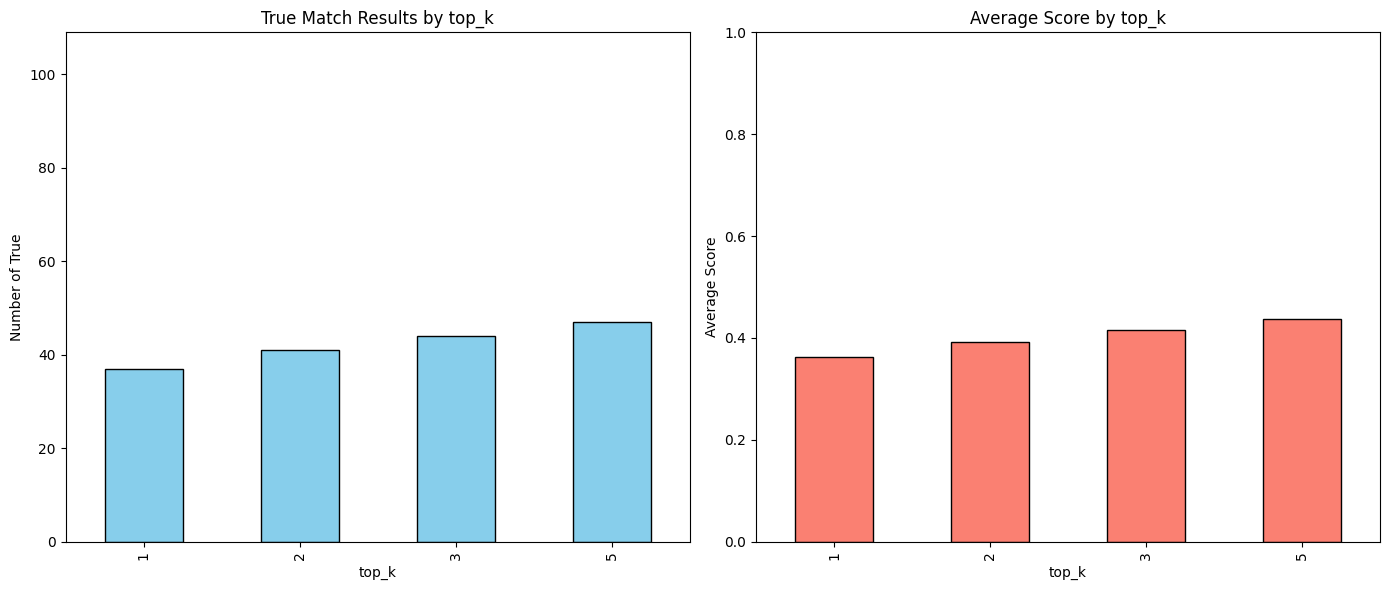

In [7]:
plot_results(top_k_results, params)

In [11]:
top_k_results.groupby('top_k')[['Match Result','Score']].agg(['sum','mean']).reset_index()

top_k Match Result                Score          
                 sum      mean        sum      mean
0     1           37  0.339450  39.553017  0.362872
1     2           41  0.376147  42.818005  0.392826
2     3           44  0.403670  45.343510  0.415996
3     5           47  0.431193  47.732659  0.437914

#### General Results

- As the `top_k` value increases, both the `Match Result` (mean) and `Score` (mean) improve. This trend indicates that retrieving more context chunks (i.e., increasing `top_k`) provides better performance in terms of both matching the correct answer and the overall score.
- The `top_k = 1` configuration yields the lowest `Match Result` (mean = 0.339450) and `Score` (mean = 0.362872). This suggests that when the system retrieves only one chunk, it might miss out on additional relevant context that could help in generating a more accurate answer.
- This makes intuitive sense because relying on a single chunk of context can be limiting. If the retrieved chunk lacks critical information or context, the model's ability to generate a correct answer diminishes.
- As `top_k` increases to `2`, `3`, and especially `5`, the `Match Result` and `Score` steadily improve. This indicates that retrieving more chunks provides the model with richer context, leading to better-informed answer generation.
- The steady improvement suggests that having access to multiple chunks allows the model to cross-reference information, resolve ambiguities, and leverage a broader set of data to produce more accurate answers.

#### Possible intuition

- With higher `top_k` values, the model has access to multiple chunks of context, which increases the likelihood of retrieving the most relevant information needed to answer the question accurately. This broader access to context can be especially beneficial in complex queries where the answer may be distributed across multiple sentences or paragraphs.
- The results suggest that there is a diminishing return as `top_k` increases. While increasing `top_k` from 1 to 5 consistently improves performance, the rate of improvement might decrease beyond a certain point. This is because, after a certain number of chunks, additional chunks might add less value, especially if they are less relevant or redundant.
- Higher `top_k` values effectively increase recall by ensuring that more potentially relevant chunks are considered. However, it also risks introducing irrelevant information that the model must filter out. The steady improvement in performance indicates that, in this case, the benefits of higher recall outweigh the potential downsides of reduced precision.

#### Conclusions
- The analysis suggests that increasing the `top_k` value from 1 to 5 improves the system's performance by providing more context for the model to generate accurate answers. The steady increase in both `Match Result` and `Score` indicates that the system benefits from retrieving multiple context chunks, which helps the model piece together a more comprehensive and accurate response.
- However, while increasing `top_k` generally improves performance, it is important to consider the trade-off between computational cost and marginal gains. Beyond a certain point, further increases in `top_k` might offer minimal additional benefit while incurring greater computational overhead. Therefore, selecting an optimal `top_k` value should balance performance improvement with efficiency. In this analysis, `top_k = 5` appears to be the best choice within the tested range, providing the highest match results and scores.